Cross-validate a model across the entire training data set. Its predictions will be stacked as features for regulatory element specific models.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import Classifier, Regression
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, CVOperator, df_cv_split
from utils import make_plots
import matplotlib.cm as cm

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


## Breakpoints

Calculate the breakpoints inside each regulatory element.

In [3]:
breakpoint_df = get_breakpoint_df(df)
# Save breakpoints to CSV
breakpoint_df.to_csv('data/cagi5_bkpt.csv')
# Look at breakpoints
breakpoint_df[breakpoint_df['is_break']!='no'].head(15)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.470,3.93,1.4900,start,NaN,True,0.0
47,X,138612684,G,T,-0.02,0.00,0,release_F9,0.048,-0.233,3.45,-2.0100,end,16.0,False,0.0
48,X,138612701,T,A,-0.36,0.37,-1,release_F9,0.009,0.470,3.27,1.9200,start,NaN,True,1.0
95,X,138612716,G,T,-0.15,0.04,0,release_F9,0.055,0.581,3.32,0.4310,end,16.0,False,1.0
96,X,138612765,C,A,0.07,0.01,0,release_F9,0.420,-0.304,4.22,0.2990,start,NaN,True,2.0
143,X,138612780,T,G,0.18,0.02,0,release_F9,0.525,0.470,4.69,4.6900,end,16.0,False,2.0
144,X,138612877,G,A,-0.09,0.05,0,release_F9,0.864,0.581,5.08,5.0800,start,NaN,True,3.0
190,X,138612892,C,T,0.12,0.01,0,release_F9,0.508,0.581,5.08,1.7900,end,16.0,False,3.0
191,X,138612909,C,A,0.05,0.02,0,release_F9,0.453,0.581,5.08,0.0736,start,NaN,True,4.0
235,X,138612924,A,G,-0.01,0.00,0,release_F9,0.614,0.470,4.55,0.6710,end,16.0,False,4.0


## Cross-validation folds

Split the training data into folds respecting the breakpoints.

In [4]:
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[1], [0], [4], [3], [2]],
 'release_GP1BB': [[2, 5], [4], [0], [1], [3]],
 'release_HBB': [[0], [2], [1], [], []],
 'release_HBG1': [[1], [2], [3], [0], []],
 'release_HNF4A': [[0], [1], [3], [2], []],
 'release_IRF4': [[0, 1], [6, 2], [5, 3], [4], [7]],
 'release_IRF6': [[1, 5], [4, 8], [7, 0], [3, 6], [2]],
 'release_LDLR': [[0], [3], [2], [1], [4]],
 'release_MSMB': [[4, 7], [8, 6], [3, 0], [5, 2], [1]],
 'release_MYCrs6983267': [[1, 3], [5, 6], [4, 2], [7, 0], [8]],
 'release_PKLR': [[1, 4], [7, 0], [2, 6], [3], [5]],
 'release_SORT1': [[1, 8], [6, 4], [2, 3], [5, 0], [7]],
 'release_TERT-GBM': [[2], [0], [1], [3], [4]],
 'release_TERT-HEK293T': [[3], [4], [1], [2], [0]],
 'release_ZFAND3': [[7, 0, 3], [8, 9], [4, 6], [1, 10], [2, 5]]}

## Create features

In [5]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
dnase = DNase()
conservation = Conservation()
enhancer1hot = EnhancerOneHot()

## Enhancer one-hot

Create stacked data without enhancer one-hot feature

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4
0.6980321423118033 0.4693747354017688


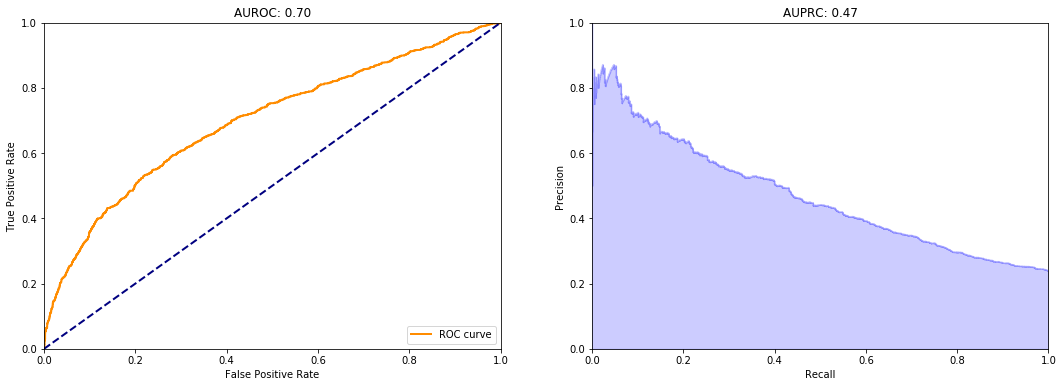

In [6]:
woe1h = MultiFeatures([deepseadiffs, dnase, conservation])
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Regression,
                       model_kwargs={'features': woe1h, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cv_woe1h = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc) = make_plots(cv_woe1h)
print(auroc, auprc)

In [7]:
tag = 'deep-dnase-cons'
cv_woe1h.to_csv('data/stacked-{}.csv'.format(tag))
np.save(
    'data/stacked-{}.npy'.format(tag),
    cv_woe1h.loc[:, ('PredValue', 'PredConfidence')].as_matrix())

## Enhancer one-hot

Create stacked data using enhancer one-hot feature

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4
0.7001523133302795 0.4739581099808514


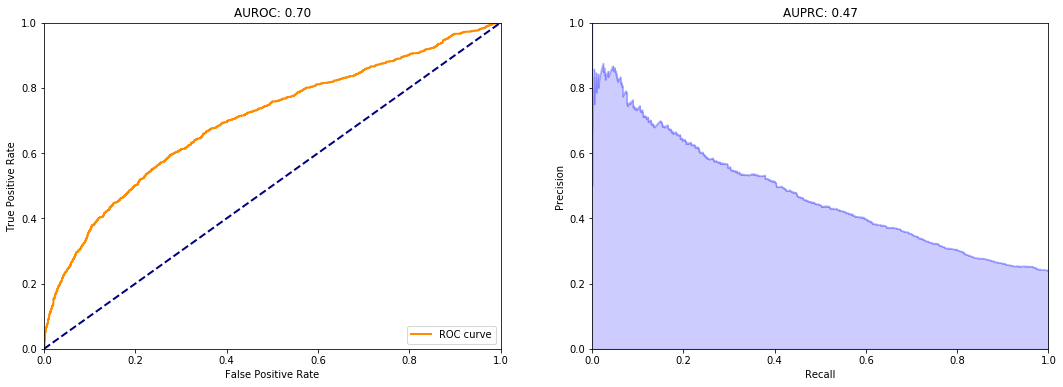

In [8]:
multi = MultiFeatures([deepseadiffs, dnase, conservation, enhancer1hot])
cv_chunk = ChunkCV(df,
                   operator=CVOperator(
                       Regression,
                       model_kwargs={'features': multi, 'model_name': 'xgb'}),
                   fold_dict=fold_dict)
cv_regress = cv_chunk.get_cv_preds()
(fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc) = make_plots(cv_regress)
print(auroc, auprc)

In [10]:
tag = 'deep-e1h-dnase-cons'
cv_regress.to_csv('data/stacked-{}.csv'.format(tag))
np.save(
    'data/stacked-{}.npy'.format(tag),
    cv_regress.loc[:, ('PredValue', 'PredConfidence')].as_matrix())

## Add some more plots

In [11]:
cv_regress.head(6)

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS,is_break,chunk_length,is_start,chunk_id,is_train,PredConfidence,PredValue
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490,start,NaN,True,0,True,0.076165,-0.227500
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490,no,NaN,False,0,True,0.123619,-0.153652
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490,no,NaN,False,0,True,0.072262,-0.205679
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337,no,NaN,False,0,True,0.204031,-0.188578
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337,no,NaN,False,0,True,0.226188,-0.172260
5,X,138612670,A,T,0.12,0.03,0,release_F9,0.008,0.47,3.93,0.337,no,NaN,False,0,True,0.080668,-0.250681


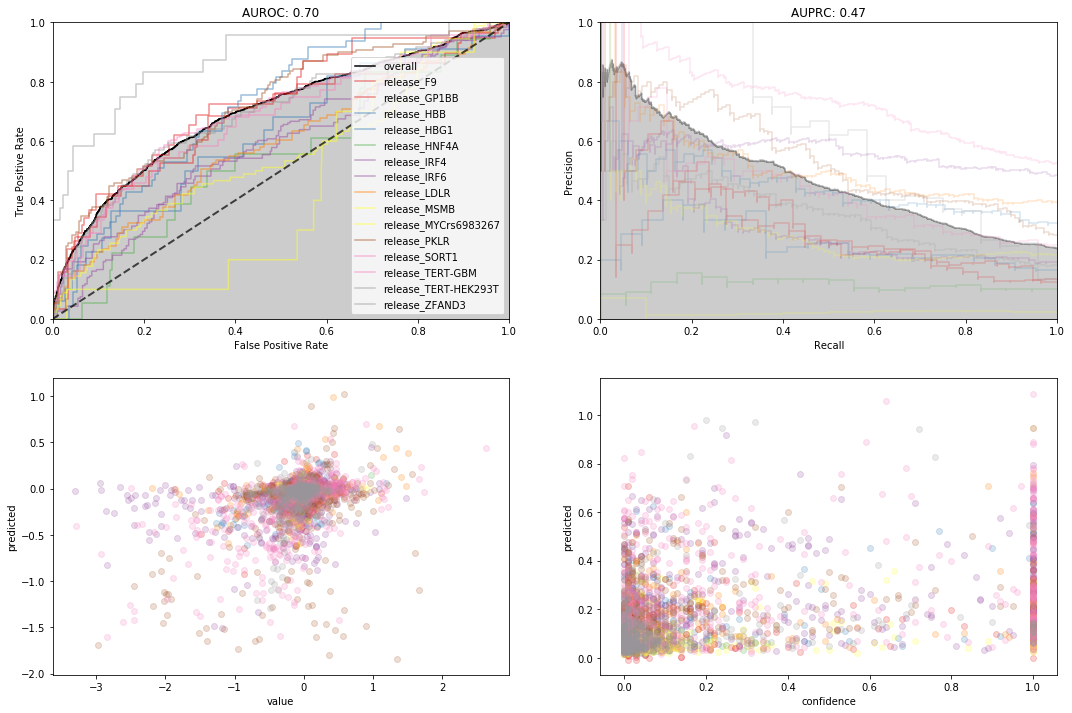

In [65]:
import importlib, utils
importlib.reload(utils)
_ = utils.make_plots(cv_regress)